In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

In [6]:
with open('names.txt') as f:
    content = f.read()
    words = content.splitlines()

In [7]:
len(words)

32033

In [8]:
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [98]:
import torch

# Context length of how many characters support the prediction. This is consistent with
# the paper we're following
block_size = 3

x, y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        x.append(context)
        y.append(ix)
        #print(''.join(itos[i] for i in context), "--->", ch)
        # Advance the rolling window of context
        context = context[1:] + [ix]


X = torch.tensor(x)
Y = torch.tensor(y)

In [99]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [336]:
# Build dataset splits
def build_dataset(words: list[str]) -> (torch.tensor, torch.tensor):
    block_size = 3

    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), "--->", ch)
            # Advance the rolling window of context
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


# Embedding Lookup table

In [337]:
import torch.nn.functional as F

# C is the lookup table which is the first layer of the network
C = torch.randn((27, 2))
C.shape

torch.Size([27, 2])

In [338]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

# Hidden Layer

In [339]:
W1 = torch.randn((6, 100))
b = torch.randn(100)

In [340]:
# Hidden layer of activations for examples

# torch.concat(emb[:, 0, :], emb[:, 1, :], emb[:, 2, :])
# torch.unbind(emb, 1), 1)
h = torch.tanh(emb.view(-1, 6) @ W1 + b)
h.shape

torch.Size([228146, 100])

# Output layer

In [341]:
W2 = torch.randn((100,27))
B2 = torch.randn(27)
logits = h @ W2 + B2
logits.shape

torch.Size([228146, 27])

In [342]:
counts = logits.exp()
counts.shape

torch.Size([228146, 27])

In [343]:
probs = counts / counts.sum(1, keepdim=True)
probs.shape

torch.Size([228146, 27])

# Negative Log Likelihood Loss

In [344]:
# Current probabilities to the correct character in the sequence
loss = -probs[torch.arange(32), Y].log().mean()
loss.item()

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [197]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

# Cleaned Up

In [374]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300))
b1 = torch.randn(300)
W2 = torch.randn((300,27))
b2 = torch.randn(27)
parameters = [W1, b1, W2, b2]

In [375]:
# Total number of parameters
sum(p.nelement() for p in parameters)

10227

In [376]:
for p in parameters:
    p.requires_grad = True

In [377]:
# It doesn't make sense to step through the learning rate linearly. Instead, we'll
# step through the exponents linearly.
lre = torch.linspace(-3, 0, steps=1000)
lrs = 10**lre

In [390]:
lri = []
lossi = []
stepi = []
for i in range(30000):
    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # (32)

    # Forward Pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.item())
    #lri.append(lre[i])
print(loss.item())


2.781233549118042


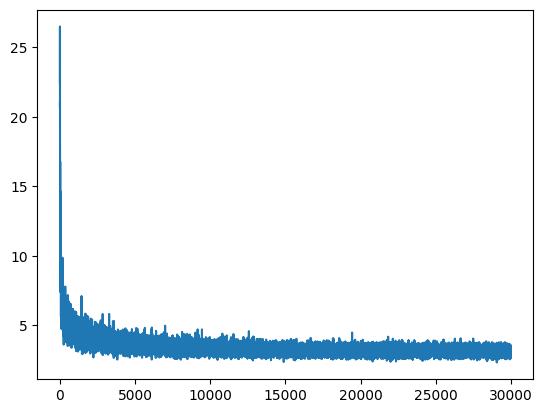

In [379]:
plt.plot(stepi, lossi)

In [391]:
# Loss on dev set
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.863650321960449


In [392]:
# Loss on entire training set
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.8622002601623535


In [108]:
torch.randint(0, X.shape[0], (32,))

tensor([126974, 122648, 106475, 119500, 162874,  73571,  29929, 182290, 157809,
        108370,  55131,   9641, 146664, 186133, 225798, 133006, 214503,  56939,
        157527,  44108, 117356, 223455,  83803,  76526,  30254,  16558, 149447,
        163322, 106977,  58725,  97484, 185403])